<a href="https://colab.research.google.com/github/jacquelsn/IA-/blob/https%2Fcolab.research.google.com%2Fdrive%2F1cMPkWtq0mPav13-Sn3uc-BxjSmrcSYLY/PLN_5_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carga e preparação dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
import os, sys, time, random
import h5py
import numpy as np
print(os.listdir("drive/MyDrive/Professor/2020-2/Nanodegree - PLN/Dataset/por-eng"))

['_about.txt', 'por.txt']


In [ ]:
BATCH_SIZE = 64  # Batch size
NB_EPOCH = 100  # Número de épocas
latent_dim = 256  # Dimensão do espaço de encoding
num_samples = 10000  # Número de exemplos a serem treinados
# Caminho do arquivo no Google Drive
data_path = "drive/MyDrive/Professor/2020-2/Nanodegree - PLN/Dataset/por-eng/por.txt"

In [ ]:
%%time
# Modelagem matemática
input_texts = [] # Textos de entrada
target_texts = [] # Textos de saída
input_characters = set() # Caracteres de entrada
target_characters = set() # Caracteres de saída
i = 0
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text  = line.split('\t',2)[:2]
    i = i + 1
    if i%500 == 0:
      print('Processing',i,input_text,target_text)
    # Usaremos "\t" como caractere inicial e "\n" como caractere final
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Processing 500 I'm tall. Eu sou alto.
Processing 1000 Look here. Olhe aqui.
Processing 1500 I think so. Acredito que sim.
Processing 2000 Who saw me? Quem me viu?
Processing 2500 I trust Tom. Eu confio em Tom.
Processing 3000 Tom cringed. Tom se encolheu.
Processing 3500 Did Tom call? Tom ligou?
Processing 4000 I'm a priest. Sou sacerdote.
Processing 4500 They are big. Eles são grandes.
Processing 5000 Will it rain? Será que vai chover?
Processing 5500 I do like Tom. Eu gosto muito do Tom.
Processing 6000 I'm busy here. Estou ocupado aqui.
Processing 6500 She got angry. Ela ficou brava.
Processing 7000 Tom was weary. O Tom estava cansado.
Processing 7500 Are you hungry? Você está com fome?
Processing 8000 I didn't sleep. Eu não dormi.
Processing 8500 I'm a diabetic. Sou diabética.
Processing 9000 Let's get them. Vamos pegá-las.
Processing 9500 They're stupid. Elas são estúpidas.
Processing 10000 We fight a lot. Nós brigamos muito.
CPU times: user 134 ms, sys: 55.8 ms, total: 189 ms
Wal

In [ ]:
%%time
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 86
Max sequence length for inputs: 15
Max sequence length for outputs: 45
CPU times: user 2.21 ms, sys: 58 µs, total: 2.27 ms
Wall time: 2.08 ms


In [ ]:
# Compreendendo o vocabulário
print('input_characters',input_characters)
print('target_characters',target_characters)

input_characters [' ', '!', '#', '$', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
target_characters ['\t', '\n', ' ', '!', '"', '$', ',', '-', '.', '0', '1', '2', '3', '4', '5', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'Â', 'É', 'à', 'á', 'â', 'ã', 'ç', 'é', 'ê', 'í', 'ó', 'ô', 'õ', 'ú', 'ă', '\u200e']


### Modelagem estatística

In [ ]:
%%time
# Criando o dataset
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
# Criando a entrada do encoder, do decoder e da saída esperada
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data está na frente do decoder_input_data por um timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data estará na frente por um timestep e não vai incluir o caractere de início '/t'
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
print('Spape of encoder_input_data',encoder_input_data.shape)
print('Spape of decoder_input_data',decoder_input_data.shape)
print('Spape of decoder_target_data',decoder_target_data.shape)

Spape of encoder_input_data (10000, 15, 70)
Spape of decoder_input_data (10000, 45, 86)
Spape of decoder_target_data (10000, 45, 86)
CPU times: user 226 ms, sys: 119 ms, total: 345 ms
Wall time: 345 ms


In [ ]:
# Compreendendo os dados de treinamento
print('encoder_input_data',encoder_input_data[0].shape)
print('decoder_input_data',decoder_input_data[0].shape)
print('decoder_target_data',decoder_target_data[0].shape)

encoder_input_data (15, 70)
decoder_input_data (45, 86)
decoder_target_data (45, 86)


Podemos ver que na entrada temos um comprimento máximo de 15 e um vocabulário de 70 caracteres diferentes

Na saída temos um comprimento máximo de 45 caracteres com um vocabulário de 86 caracteres diferentes


### Seq2Seq

In [ ]:
# Criando o modelo Seq2Seq
# Criando o Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Mantendo apenas os estados
encoder_states = [state_h, state_c]
# Criando o Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# O decoder vai retornar a sequência completa e o estado interno, o qual
# não será utilizado no treinamento, mas na inferência apenas.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# O modelo final irá transformar o encoder_input_data & decoder_input_data em decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 70)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 86)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 334848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  351232      input_2[0][0]                    
                                                                 lstm[0][1]                   

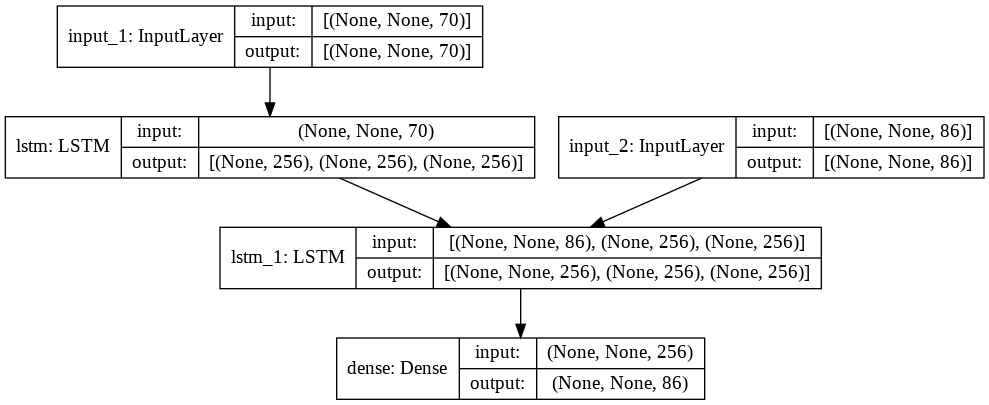

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
%%time
# Run training
from keras.optimizers import *
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCH,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 35s 19ms/step - loss: 1.1484 - accuracy: 0.0544 - val_loss: 1.1360 - val_accuracy: 0.0952
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9722 - accuracy: 0.0853 - val_loss: 1.1746 - val_accuracy: 0.0905
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9507 - accuracy: 0.0883 - val_loss: 1.0322 - val_accuracy: 0.1167
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8822 - accuracy: 0.1037 - val_loss: 0.9956 - val_accuracy: 0.1265
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8448 - accuracy: 0.1125 - val_loss: 0.9525 - val_accuracy: 0.1390
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8039 - accuracy: 0.1217 - val_loss: 0.8836 - val_accuracy: 0.1519
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 0.7471 - accuracy: 0.1356 - val_loss: 0.8596 - val_accuracy

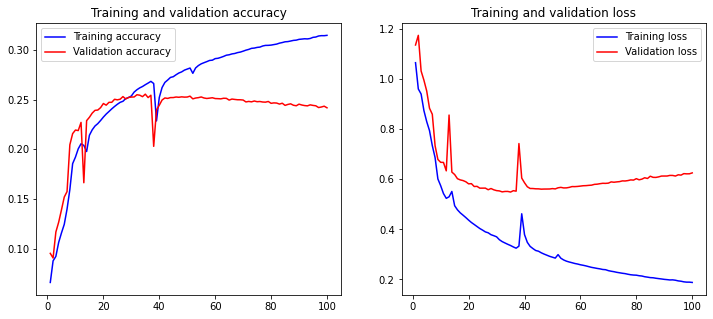

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
# Definindo modelo de previsão
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

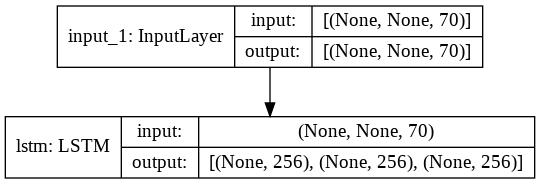

In [ ]:
# Plotando o Encoder de Inferência
plot_model(encoder_model, show_shapes=True)

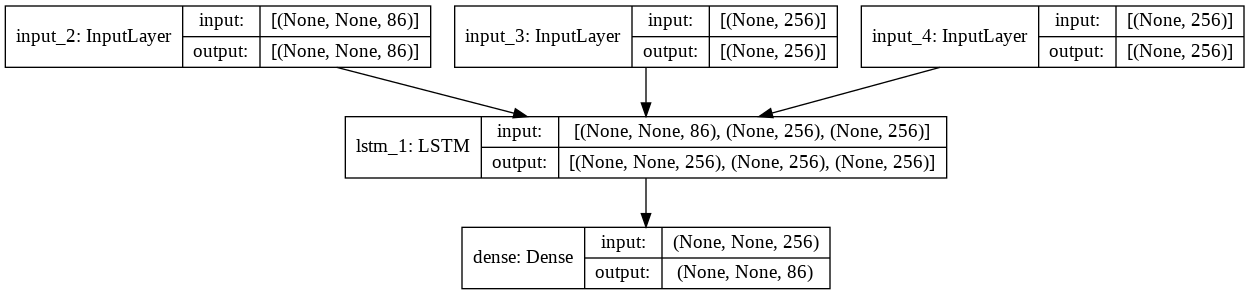

In [ ]:
# Plotando o Decoder de Inferência
plot_model(decoder_model, show_shapes=True)

In [ ]:
# Criação da função final para a tradução
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def translate_eng_por(input_seq):
    # Cria primeiro o vetor oculto de estados com o Encode (encoder_model)
    states_value = encoder_model.predict(input_seq)

    # Cria uma sequência target vazia
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Popula a sequência com o caractere '\t'
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Loop para formar a saída utilizando o Decoder (decoder_model), até encontrar '\n' ou o limite de caracteres
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Para cada token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Condição de parada, caso encontre o tamanho máximo ou '\n'
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        # Atualiza a sequência de saída (target_seq)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        # atualiza os estados para a próxima previsão
        states_value = [h, c]
    return decoded_sentence

In [ ]:
# Testando o modelo para os primeiros 1000 exemplos
for seq_index in range(1000):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = translate_eng_por(input_seq)
    print('-')
    print('Input:', input_texts[seq_index])
    print('Output:', decoded_sentence)

-
Input: Go.
Output: Vo.

-
Input: Go.
Output: Vo.

-
Input: Hi.
Output: Oi.

-
Input: Run!
Output: Corra!

-
Input: Run!
Output: Corra!

-
Input: Run!
Output: Corra!

-
Input: Run.
Output: Corra!

-
Input: Run.
Output: Corra!

-
Input: Run.
Output: Corra!

-
Input: Who?
Output: Que                                           
-
Input: Who?
Output: Que                                           
-
Input: Wow!
Output: Coram.

-
Input: Wow!
Output: Coram.

-
Input: Wow!
Output: Coram.

-
Input: Fire!
Output: Soram.

-
Input: Fire!
Output: Soram.

-
Input: Fire!
Output: Soram.

-
Input: Help!
Output: Ajuda!

-
Input: Help!
Output: Ajuda!

-
Input: Jump!
Output: Pulem.

-
Input: Jump!
Output: Pulem.

-
Input: Jump.
Output: Pulem.

-
Input: Jump.
Output: Pulem.

-
Input: Jump.
Output: Pulem.

-
Input: Stop!
Output: Parem.

-
Input: Stop!
Output: Parem.

-
Input: Stop!
Output: Parem.

-
Input: Stop!
Output: Parem.

-
Input: Stop!
Output: Parem.

-
Input: Wait!
Output: Espere!

-
Input: Wait!
Ou

FIM